## Imports

In [1]:
import os
import cv2
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from tqdm.auto import tqdm
# from tqdm.notebook import tqdm
# from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn

from IPython.display import display, HTML
from archs import ResEmoteNetPT, DDAMPT, MixedFeatureNetPT
from utils.utils import *

## Check CUDA

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == "cuda":
    print("Device:", torch.cuda.get_device_name(0))
else:
    print("Device: CPU")

PyTorch version: 2.2.2
CUDA is available
Device: NVIDIA GeForce RTX 3060 Ti


## Define Paths and global variables

In [3]:
BASE_PATH = ""

MODEL_NAME = "DDAMFN"  #DDAMFN, ResNet_pretrained, ResNet, ResEmoteNet
DATASET = "fer2013plus_new"       #fer2013plus_new, fer13_new

if DATASET == "fer2013plus_new":
    DATA_PATH = os.path.join(BASE_PATH, "data", "fer2013plus_new")
    WEIGHT_PATH = os.path.join(BASE_PATH, "weights", "fer2013plus_new")
    NUM_CLASSES = 8

elif DATASET == "fer13_new":
    DATA_PATH = os.path.join(BASE_PATH, "data", "fer2013_new")
    WEIGHT_PATH = os.path.join(BASE_PATH, "weights", "fer2013_new", MODEL_NAME)
    NUM_CLASSES = 7

else:
    raise ValueError(f"Unsupported dataset: {DATASET}")

In [4]:
if MODEL_NAME=="ResEmoteNet":
    IMAGE_SIZE = 64
    BATCH_SIZE = 64
elif MODEL_NAME=="DDAMFN":
    IMAGE_SIZE = 112
    BATCH_SIZE = 64
elif MODEL_NAME=="ResNet_pretrained":
    IMAGE_SIZE = 224
    BATCH_SIZE = 64
elif MODEL_NAME=="ResNet":
    IMAGE_SIZE = 224
    BATCH_SIZE = 64
else:
    raise ValueError(f"Unsupported model: {MODEL_NAME}")

## Set Seed

In [5]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

torch.cuda.manual_seed_all(SEED)
eps = sys.float_info.epsilon

## Make data loaders

In [6]:
train_path = os.path.join(DATA_PATH, "train")
val_path   = os.path.join(DATA_PATH, "val")
test_path  = os.path.join(DATA_PATH, "test")

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),        
    transforms.RandomApply([
        transforms.RandomRotation(10),
        transforms.RandomCrop(IMAGE_SIZE, padding=int(16*(IMAGE_SIZE/112)))], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(scale=(0.02,0.25))])


val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Load datasets using ImageFolder (assuming images are organized in subfolders by class)
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)#, num_workers=8
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Example to check the data loaders:
print("Training DataLoader:", len(train_loader.dataset))
print("Validation DataLoader:", len(val_loader.dataset))
print("Test DataLoader:", len(test_loader.dataset))

Training DataLoader: 25543
Validation DataLoader: 2843
Test DataLoader: 7099


## Show examples

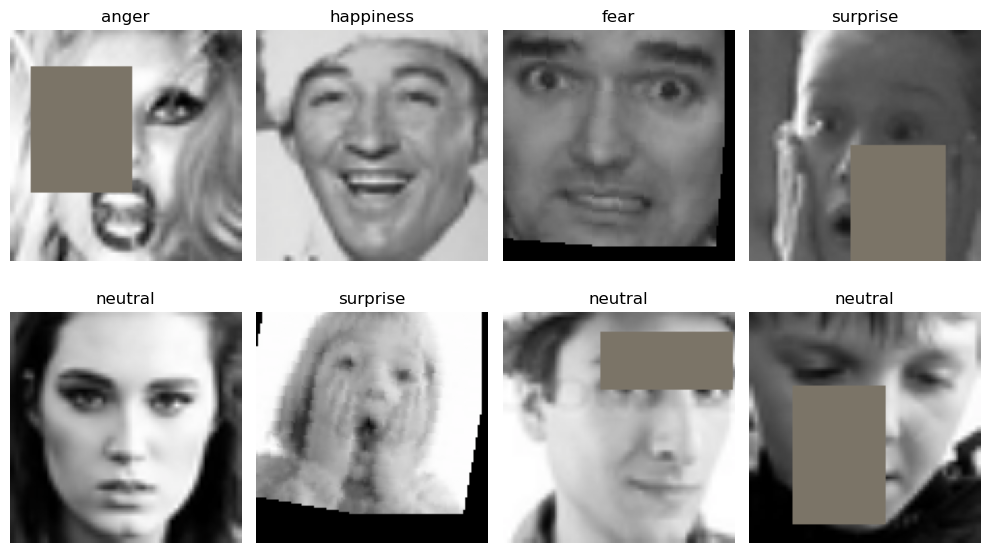

In [7]:
# Get a batch of images and labels from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)  # images: (B, C, H, W) normalized

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# Convert images to numpy arrays and transpose from (C, H, W) to (H, W, C) and denormalize
images = images.numpy().transpose(0, 2, 3, 1)
images = images * std + mean
images = np.clip(images, 0, 1)

class_names = train_loader.dataset.classes

# Create a figure with 8 subplots
fig, axes = plt.subplots(2, 4, figsize=(10, 6))
axes = axes.ravel()

# Loop through the first 8 images in the batch and display them
for i in range(8):
    axes[i].imshow(images[i])
    axes[i].axis("off")
    axes[i].set_title(class_names[labels[i].item()])

plt.tight_layout()
plt.show()

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

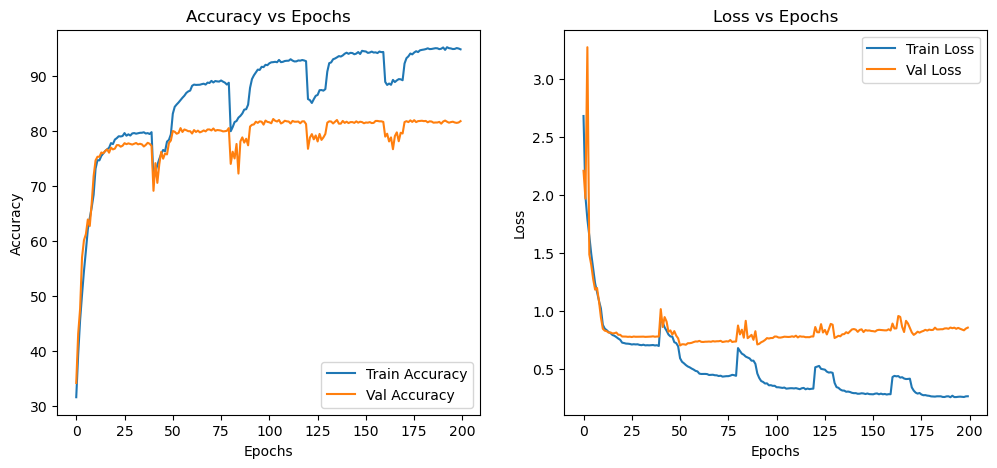

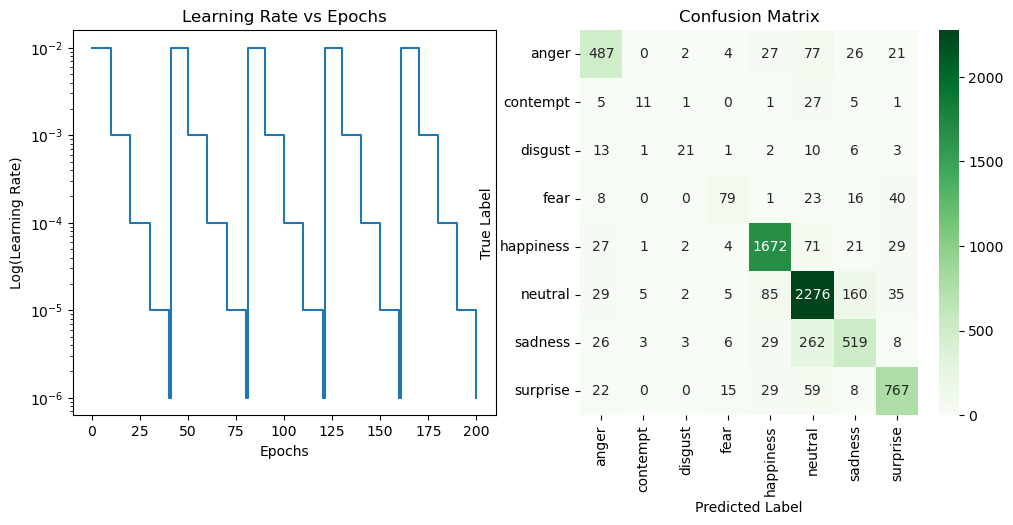

In [8]:
if MODEL_NAME=="ResEmoteNet":
    model = ResEmoteNetPT.ResEmoteNet(num_classes=NUM_CLASSES)
    history_df = train_FER(
        model=model,
        learning_rate=1e-2, 
        num_epochs=120,
        weight_path=WEIGHT_PATH,
        train_loader=train_loader, 
        val_loader=val_loader, 
        test_loader=test_loader, 
        model_name = MODEL_NAME,
        device=device, 
        verbose=True)
elif MODEL_NAME=="DDAMFN":
    pretrained_address = os.path.join('./weights/fer2013plus_new/DDAMPT', "best_model.pth")
    model = DDAMPT.DDAMNet(num_class=NUM_CLASSES, num_head=2, pretrained=False, pretrained_address=pretrained_address)
    history_df = train_FER(
        model=model,
        learning_rate=1e-2, 
        num_epochs=200,
        weight_path=WEIGHT_PATH,
        train_loader=train_loader, 
        val_loader=val_loader, 
        test_loader=test_loader, 
        model_name = MODEL_NAME,
        device=device, 
        verbose=True)
elif  MODEL_NAME=="ResNet_pretrained":
    model = ResNet(num_classes=NUM_CLASSES, pretrained=True)
    history_df = train_FER(
        model=model,
        learning_rate=3e-3, 
        num_epochs=40,
        weight_path=WEIGHT_PATH,
        train_loader=train_loader, 
        val_loader=val_loader, 
        test_loader=test_loader, 
        model_name = MODEL_NAME,
        device=device, 
        verbose=True)
elif MODEL_NAME=="ResNet":
    model = ResNet(num_classes=NUM_CLASSES, pretrained=False)
    history_df = train_FER(
        model=model,
        learning_rate=3e-3, 
        num_epochs=120,
        weight_path=WEIGHT_PATH,
        train_loader=train_loader, 
        val_loader=val_loader, 
        test_loader=test_loader, 
        model_name = MODEL_NAME,
        device=device,
        verbose=True)
else:
    raise ValueError(f"Unsupported model: {MODEL_NAME}")

In [9]:
pd.options.display.float_format = "{:,.2f}".format
display(pd.DataFrame({'result': history_df.iloc[-1]}).T)

,train_loss,val_loss,train_accuracy,val_accuracy,test_loss,test_accuracy
result,0.26,0.85,94.91,81.85,0.73,82.15
